In [1]:
from sklearn.tree import DecisionTreeRegressor

from sklearn import model_selection
import numpy as np

from sklearn.datasets import load_diabetes

In [2]:
X, y = load_diabetes(return_X_y=True)

In [3]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25)

In [4]:
def gb_predict(X, trees_list, coef_list, eta):
    return np.array([sum([eta* coef * alg.predict([x])[0] for alg, coef in zip(trees_list, coef_list)]) for x in X])

In [5]:
def mse(y_real, prediction):
    return np.mean((y_real - prediction)**2)

In [6]:
def bias(y, z):
    return (y - z)

In [7]:
def gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta):
    
    # Деревья будем записывать в список
    trees = []
    
    # Будем записывать ошибки на обучающей и тестовой выборке на каждой итерации в список
    train_errors = []
    test_errors = []
    
    for i in range(n_trees):
        tree = DecisionTreeRegressor(max_depth=max_depth, random_state=42)

        # инициализируем бустинг начальным алгоритмом, возвращающим ноль, 
        # поэтому первый алгоритм просто обучаем на выборке и добавляем в список
        # алгоритмы начиная со второго обучаем на сдвиг
        tree.fit(X_train, y_train if len(trees) == 0 else bias(y_train, gb_predict(X_train, trees, coefs, eta)))
            
        train_errors.append(mse(y_train, gb_predict(X_train, trees, coefs, eta)))
        test_errors.append(mse(y_test, gb_predict(X_test, trees, coefs, eta)))

        trees.append(tree)
        
    return trees, train_errors, test_errors

In [8]:
# Число деревьев в ансамбле
n_trees = 20

# для простоты примем коэффициенты равными 1
coefs = [1] * n_trees

# Максимальная глубина деревьев
max_depth = 3

# Шаг
eta = 0.1

trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)

In [9]:
def evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta):
    train_prediction = gb_predict(X_train, trees, coefs, eta)

    print(f'Ошибка алгоритма из {n_trees} деревьев глубиной {max_depth} \
    с шагом {eta} на тренировочной выборке: {mse(y_train, train_prediction)}')

    test_prediction = gb_predict(X_test, trees, coefs, eta)

    print(f'Ошибка алгоритма из {n_trees} деревьев глубиной {max_depth} \
    с шагом {eta} на тестовой выборке: {mse(y_test, test_prediction)}')

In [10]:
evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta)

Ошибка алгоритма из 20 деревьев глубиной 3     с шагом 0.1 на тренировочной выборке: 2526.4596600564482
Ошибка алгоритма из 20 деревьев глубиной 3     с шагом 0.1 на тестовой выборке: 3162.8228927938744


In [11]:
import matplotlib.pyplot as plt

In [12]:
def get_error_plot(n_trees, train_err, test_err):
    plt.xlabel('Iteration number')
    plt.ylabel('MSE')
    plt.xlim(0, n_trees)
    plt.plot(list(range(n_trees)), train_err, label='train error')
    plt.plot(list(range(n_trees)), test_err, label='test error')
    plt.legend(loc='upper right')
    plt.show()

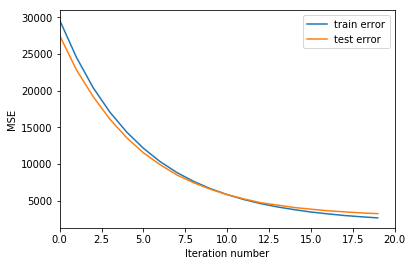

In [13]:
get_error_plot(n_trees, train_errors, test_errors)

In [14]:
def get_error_plot_by_trees(trees_amounts, train_err, test_err):
    plt.xlabel('Trees amount')
    plt.ylabel('MSE')
    plt.xlim(min(trees_amounts), max(trees_amounts))
    plt.plot(trees_amounts, train_err, label='train error')
    plt.plot(trees_amounts, test_err, label='test error')
    plt.legend(loc='upper right')
    plt.show()

In [15]:
def get_error_plot_by_depth(depths, train_err, test_err):
    plt.xlabel('Trees max depth')
    plt.ylabel('MSE')
    plt.xlim(min(depths), max(depths))
    plt.plot(depths, train_err, label='train error')
    plt.plot(depths, test_err, label='test error')
    plt.legend(loc='upper right')
    plt.show()

In [16]:
eta = 0.1
trees_amounts = [1, 3, 5, 10, 20, 30]
ta_train_err = []
ta_test_err = []

for tree_n in trees_amounts:
    coefs = [1] * tree_n
    trees, train_errors, test_errors = gb_fit(tree_n, max_depth, X_train, X_test, y_train, y_test, coefs, eta)

    train_prediction = gb_predict(X_train, trees, coefs, eta)
    ta_train_err.append(mse(y_train, train_prediction))
    
    test_prediction = gb_predict(X_test, trees, coefs, eta)
    ta_test_err.append(mse(y_test, test_prediction))

In [17]:
# get_error_plot_by_trees(trees_amounts, train_errors, test_errors)
# trees_amounts, ta_train_err, ta_test_err

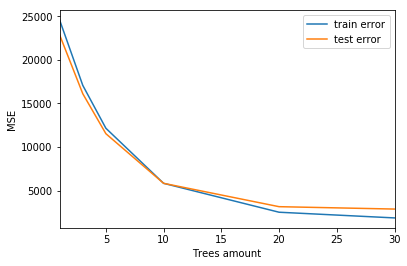

In [18]:
get_error_plot_by_trees(trees_amounts, ta_train_err, ta_test_err)

In [19]:
depthes = np.arange(1, 6)
d_train_err = []
d_test_err = []

for m_depth in depthes:
    coefs = [1] * n_trees
    trees, train_errors, test_errors = gb_fit(n_trees, m_depth, X_train, X_test, y_train, y_test, coefs, eta)

    train_prediction = gb_predict(X_train, trees, coefs, eta)
    d_train_err.append(mse(y_train, train_prediction))
    
    test_prediction = gb_predict(X_test, trees, coefs, eta)
    d_test_err.append(mse(y_test, test_prediction))

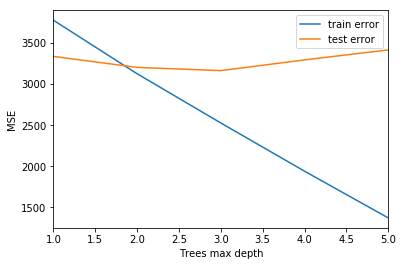

In [20]:
get_error_plot_by_depth(depthes, d_train_err, d_test_err)

Видим, что ошибка постепенно начинает уменьшатся при увеличении количества деревьей или их глубины. В то же время графики связанные с грлубиной начинают расходиться - это связано со значением eta. Если понизить eta до 0.01 увидим, что графики сходятся

In [21]:
def sgb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta, subset=0.5):
    
    # Деревья будем записывать в список
    trees = []
    
    # Будем записывать ошибки на обучающей и тестовой выборке на каждой итерации в список
    train_errors = []
    test_errors = []
    
    for i in range(n_trees):
        tree = DecisionTreeRegressor(max_depth=max_depth, random_state=42)

        # получаем подвыборку размером subset
        indexes = np.random.choice(X_train.shape[0], int(X_train.shape[0] * subset))

        # инициализируем бустинг начальным алгоритмом, возвращающим ноль, 
        # поэтому первый алгоритм просто обучаем на выборке и добавляем в список
        # алгоритмы начиная со второго обучаем на сдвиг    
        tree.fit(X_train[indexes], y_train[indexes] if len(trees) == 0 else bias(y_train[indexes], gb_predict(X_train[indexes], trees, coefs, eta)))
            
        train_errors.append(mse(y_train[indexes], gb_predict(X_train[indexes], trees, coefs, eta)))
        test_errors.append(mse(y_test, gb_predict(X_test, trees, coefs, eta)))

        trees.append(tree)
        
    return trees, train_errors, test_errors

In [22]:
# Число деревьев в ансамбле
n_trees = 20

# для простоты примем коэффициенты равными 1
coefs = [1] * n_trees

# Максимальная глубина деревьев
max_depth = 3

# Шаг
eta = 0.1

In [23]:
trees, train_errors, test_errors = sgb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta, subset=0.7)

In [24]:
evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta)

Ошибка алгоритма из 20 деревьев глубиной 3     с шагом 0.1 на тренировочной выборке: 2686.19701471661
Ошибка алгоритма из 20 деревьев глубиной 3     с шагом 0.1 на тестовой выборке: 3111.5586815809766


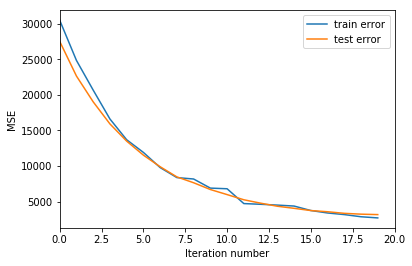

In [25]:
get_error_plot(n_trees, train_errors, test_errors)

Немножко поиграл с параметрами. Видим, что графики медленно сходятся и вглядит это более плавно, чем при простом бустинге